# Introduction #

Recall from the example in the previous lesson that Keras will keep a history of the training and validation loss over the epochs that it is training the model. In this lesson, we're going to learn how to interpret these learning curves and how we can use them to guide model development. In particular, we'll examine at the learning curves for evidence of *underfitting* and *overfitting* and look at a couple of strategies for correcting it.

# Interpreting the Learning Curves #

You might think about the information in the training data as being of two kinds: *signal* and *noise*. The signal is the part that generalizes, the part that can help our model make predictions from new data. The noise is that part that is *only* true of the training data; the noise is all of the random fluctuation that comes from data in the real-world or all of the incidental, non-informative patterns that can't actually help the model make predictions. The noise is the part might look useful but really isn't.

We train a model by choosing weights or parameters that minimize the loss on a training set. You might know, however, that to accurately assess a model's performance, we need to evaluate it on a new set of data, the *validation* data. (You could see our lesson on [model validation](https://www.kaggle.com/dansbecker/model-validation) in *Introduction to Machine Learning* for a review.)

When we train a model we've been plotting the loss on the training set epoch by epoch. To this we'll add a plot the validation data too. These plots we call the **learning curves**. To train deep learning models effectively, we need to be able to interpret them.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/tHiVFnM.png" width="500" alt="A graph of training and validation loss.">
<figcaption style="textalign: center; font-style: italic"><center>The validation loss gives an estimate of the expected error on unseen data.
</center></figcaption>
</figure>

Now, the training loss will go down either when the model learns signal or when it learns noise. But the validation loss will go down only when the model learns signal. (Whatever noise the model learned from the training set won't generalize to new data.) So, when a model learns signal both curves go down, but when it learns noise a *gap* is created in the curves. The size of the gap tells you how much noise the model has learned.

Ideally, we would create models that learn all of the signal and none of the noise. This will practically never happen. Instead we make a trade. We can get the model to learn more signal at the cost of learning more noise. So long as the trade is in our favor, the validation loss will continue to decrease. After a certain point, however, the trade can turn against us, the cost exceeds the benefit, and the validation loss begins to rise.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/eUF6mfo.png" width="600" alt="Two graphs. On the left, a line through a few data points with the true fit a parabola. On the right, a curve running through each datapoint with the true fit a parabola.">
<figcaption style="textalign: center; font-style: italic"><center>Underfitting and overfitting.
</center></figcaption>
</figure>

This trade-off indicates that there can be two problems that occur when training a model: not enough signal or too much noise. **Underfitting** the training set is when the loss is not as low as it could be because the model hasn't learned enough *signal*. **Overfitting** the training set is when the loss is not as low as it could be because the model learned too much *noise*. The trick to training deep learning models is finding the best balance between the two.

We'll look at a couple ways of getting more signal out of the training data while reducing the amount of noise.

# Capacity #

A model's **capacity** refers to the size and complexity of the patterns it is able to learn. For neural networks, this will largely be determined by how many neurons it has and how they are connected together. If it appears that your network is underfitting the data, you should try increasing its capacity.

You can increase the capacity of a network either by making it *wider* (more units to existing layers) or by making it *deeper* (adding more layers). Wider networks have an easier time learning more linear relationships, while deeper networks prefer more nonlinear ones. Which is better just depends on the dataset.

```
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

wider = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])

deeper = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])
```

You'll explore how the capacity of a network can affect its performance in the exercise.

# Early Stopping #

We mentioned that when a model is too eagerly learning noise, the validation loss may start to increase during training. To prevent this, we can simply stop the training whenever it seems the validation loss isn't decreasing anymore. Interrupting the training this way is called **early stopping**.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/eP0gppr.png" width=500 alt="A graph of the learning curves with early stopping at the minimum validation loss, underfitting to the left of it and overfitting to the right.">
<figcaption style="textalign: center; font-style: italic"><center>We keep the model where the validation loss is at a minimum.
</center></figcaption>
</figure>

Once we detect that the validation loss is starting to rise again, we can reset the weights back to where the minimum occured. This ensures that the model won't continue to learn noise and overfit the data.

Training with early stopping also means we're in less danger of stopping the training too early, before the network has finished learning signal. So besides preventing overfitting from training too long, early stopping can also prevent *underfitting* from not training long enough. Just set your training epochs to some large number (more than you'll need), and early stopping will take care of the rest.

## Adding Early Stopping ##

In Keras, we include early stopping in our training through a callback. A **callback** is just a function you want run every so often while the network trains. The early stopping callback will run after every epoch. (Keras has [a variety of useful callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) pre-defined, but you can [define your own](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback), too.)

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

These parameters say: "If there hasn't been at least an improvement of 0.001 in the validation loss over the previous 20 epochs, then stop the training and keep the best model you found." It can sometimes be hard to tell if the validation loss is rising due to overfitting or just due to random batch variation. The parameters allow us to set some allowances around when to stop.

As we'll see in our example, we'll pass this callback to the `fit` method along with the loss and optimizer.

# Example - Train a Model with Early Stopping #

Let's continue developing the model from the example in the last tutorial. We'll increase the capacity of that network but also add an early-stopping callback to prevent overfitting.

Here's the data prep again.

In [3]:
import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('../input/dl-course-data/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


Now let's increase the capacity of the network. We'll go for a fairly large network, but rely on the callback to halt the training once the validation loss shows signs of increasing.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)

2022-08-23 16:30:02.431385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


After defining the callback, add it as an argument in `fit` (you can have several, so put it in a list). Choose a large number of epochs when using early stopping, more than you'll need.

Minimum validation loss: 0.0912136510014534


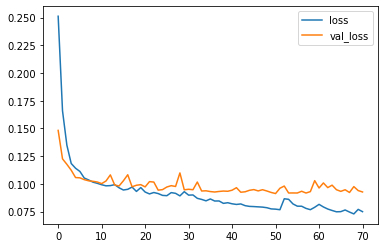

In [5]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

And sure enough, Keras stopped the training well before the full 500 epochs!

# Your Turn #

Now [**predict how popular a song is**](./5-dropout-and-batch-normalization.ipynb) with the *Spotify* dataset.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*